# 3. Feature Engineering, Extraction and Selection

This section is dedicated to the feature analysis: I am going to apply lemmatizing, encoding and vectorization in order to obtain a sparse matrix of words along with a numerical target variable. This is essential to run the models.

## Importing Dependencies

In [92]:
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import json
import re
import nltk
from nltk.stem  import WordNetLemmatizer
from prettytable import PrettyTable
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import umap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2

import warnings
warnings.filterwarnings('ignore')

In [93]:
plt.style.use('ggplot')

In [94]:
df = pd.read_csv('G:/Il mio Drive/MAGISTRALE/IT Coding/Project/Sentiment-Analysis-on-Amazon-product-reviews/Data/after_EDA_revs.csv')
df.drop(columns=['Unnamed: 0', 'Id'], inplace=True)
df.head(3)

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,pipeline_score,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day,Review Length,Word Count
0,0.000,0.505,0.495,0.8687,0.001822,0.019103,0.979074,0.99988,good sound seem decent build quality good soun...,good sound. seem decent build quality and good...,good sound,seem decent build quality and good sound. very...,5,Positive,2023,5,28,79,13
1,0.028,0.735,0.238,0.9677,0.107382,0.198000,0.694618,0.99909,not realise bad audio setup considering used q...,i didn't realise how bad my audio setup was. c...,i didn't realise how bad my audio setup was,considering i used to have quite a respectable...,5,Positive,2023,5,27,521,94
2,0.000,0.429,0.571,0.8402,0.002566,0.017258,0.980176,0.99988,beauty love compact shape sound,its a beauty. love its compact shape and sound,its a beauty,love its compact shape and sound,5,Positive,2023,5,26,46,9


## Feature Engineering

- Lemmatize all clean reviews
- Encoding sentiment's labels
- Word Embedding using TD-IDF Vectorizer (and visualizing the sparse matrix)
- SMOTE for sample imbalance

### Lemmatization

In this part I am going to define a function which will **lemmatize** all the words in the sentences of the 'Clean Review' column. 

But what does lemmatize mean? A lemma is a word that represents a whole group of words, so lemmatizing consists in reducing  words to their core meaning (doing -> do). Lemmatization generally has higher accuracy than another technique called Stemming. Lemmatization is preferred for context analysis, whereas stemming is recommended when the context is not important. Stemming is the process of reducing the inflected form of a word to its root form.

For this function I firstly used nltk word_toknenize() and pos_tag() methods to split the sentence in a list words (a.k.a. feature vector) with their respective tag. Then I proceeded to check which words the WordNetLemmatizer() could lemmatize (adjectives, nouns, adverbs and verbs), lemmatizing the words in the sentence based on their POS tags and returning the list of lemmatized words. To do that I extracted the first letter of the tag and converted it to lower case in order to use that variable in the lemmatizer.

POS tags: 
- "a" refers to adjectives
- "r" refers to adverbs
- "n" refers to nouns
- "v" refers to verbs

In [95]:
# here we can find the meaning of all the tags
# nltk.help.upenn_tagset()

In [96]:
def lemmatize(sentence):
    lemmatizer = WordNetLemmatizer()                                # define the lemmatizer

    tokens = nltk.word_tokenize(sentence)                           # tokenize sentence
    tags = nltk.pos_tag(tokens)                                     # tag each token
    list_of_tags = ['JJ', 'JJR', 'JJS',                             # adjectives
                    'NN', 'NNP', 'NNPS', 'NNS',                     # nouns
                    'RB', 'RBR', 'RBS',                             # adverbs
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']        # verbs

    lemmatized_sentence = ""
    for t in tags:
        if t[1] in list_of_tags:
            pos = t[1].lower()[0]
            if t[1][0] == 'J':
                pos = 'a'                                           # according to the 4 different pos values
        else:
            pos = None      # invariant words

        if pos != None:
            lemma = lemmatizer.lemmatize(t[0], pos=pos)
        else:
            lemma = t[0]
        lemmatized_sentence += " " + lemma                           # build the lemmatized sentence
    return lemmatized_sentence

In [97]:
df['Clean Review'] = df['Clean Review'].apply(lemmatize)
df.head(3)

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,pipeline_score,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day,Review Length,Word Count
0,0.000,0.505,0.495,0.8687,0.001822,0.019103,0.979074,0.99988,good sound seem decent build quality good sou...,good sound. seem decent build quality and good...,good sound,seem decent build quality and good sound. very...,5,Positive,2023,5,28,79,13
1,0.028,0.735,0.238,0.9677,0.107382,0.198000,0.694618,0.99909,not realise bad audio setup consider use quit...,i didn't realise how bad my audio setup was. c...,i didn't realise how bad my audio setup was,considering i used to have quite a respectable...,5,Positive,2023,5,27,521,94
2,0.000,0.429,0.571,0.8402,0.002566,0.017258,0.980176,0.99988,beauty love compact shape sound,its a beauty. love its compact shape and sound,its a beauty,love its compact shape and sound,5,Positive,2023,5,26,46,9


### Encoding sentiment's labels

Here I'm using the label encoder to convert the values (Positive, Negative, Neutral) of the Sentiment Feature into numbers.

In [98]:
encoder = LabelEncoder()

In [99]:
df['Target'] = encoder.fit_transform(df['Sentiment'])
df['Target'].unique()

array([2, 0, 1])

- 2 is Positive
- 1 is Neutral
- 0 is Negative

In [100]:
y = df['Target']
y.value_counts()

2    640
0     65
1     31
Name: Target, dtype: int64

As we already know from the EDA, there is a huge class imbalance in the Target variable. Therefore, after the Word Embedding stage, we can use a little "trick" to re-balance the classes (SMOTE).

### TD-IDF 

The aim of this section is to embed the words in each corpus. In very simple terms, **Word Embeddings** are the texts converted into numbers and there may be different numerical representations of the same text. In fact there are different types of word embeddings - One Hot Encoding, the CountVectorizer, Bag Of Words (BOW), N-grams and TD-IDF vectorization - and in this case I am going to use the TD-IDF one.

Term Frequency - Inverse Document Frequency (TF-IDF) gives a measure that takes the importance of a word into consideration depending on how frequently it occurs in a document and a corpus. The formula for finding TF-IDF is the following:

$$W_{x,y} = tf_{x,y}log(\frac{N}{df_{x}})$$

Where:
- W is the word x within the review y
- tf is the term frequency of x in y
- df is the number of reviews containing x
- N is the total number of reviews

This section is really important since it is here where the real data preparation for the models happens:
1. Splitting the data into train and test (will use cross-validation for model evaluation)
2. Creating the TF-IDF Vectorizer object
3. Use the vectorizer to fit AND transform: this method will analyze the text data in the **train set**, learn the vocabulary, and compute the TF-IDF scores for each review. Note that for the test I used only the transform method, transforming the 'Clean Review' column of the test data into a sparse matrix **using the same TF-IDF features learned from the training data**.

In [101]:
data = df[['Clean Review', 'Sentiment', 'Target']]

In [102]:
train, test = train_test_split(data,test_size=.3,random_state=42, shuffle=True)

In [103]:
tfidf = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), max_features=2500)
# I want the vectorizer to analyze words, unigrams-bigrams and trigrams
# select the top 2500 n-grams according to the tfidf values

I decided to analyze also the bigrams and trigrams (not only the unigrams) since maybe they could be helpful for predicting new reviews.

In [104]:
X_train = tfidf.fit_transform(train['Clean Review']).toarray()
X_test = tfidf.transform(test['Clean Review']).toarray()

y_train = train['Target']
y_test = test['Target']

In [105]:
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Train set shape: (515, 2500)
Test set shape: (221, 2500)


### Sparse matrix and curiosities

We obtained two sparse matrices with 2000 features, as we wanted. Basically these are matrices where every column is a n-gram and the values are the "impact" that each particular n-gram has on the entire review. Let's visualize the features and the matrix.

In [106]:
print(f'The first 10 features/n-grams of the sparse matrix are: {tfidf.get_feature_names()[:10]}')
print(f'The last 10 features/n-grams of the sparse matrix are: {tfidf.get_feature_names()[-10:]}')

The first 10 features/n-grams of the sparse matrix are: ['10', '10 10', '100', '12', '15', '25w', '2nd', '30', '40', '50']
The last 10 features/n-grams of the sparse matrix are: ['write', 'wrong', 'yamaha', 'year', 'year ago', 'yes', 'yet', 'youtube', 'youtube review', 'z506']


In [124]:
sparse_train = pd.DataFrame(X_train)
sparse_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.085159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A big curiosity I had was to see which reviews were similar. So, once I obtained the TF-IDF matrix I thought I could use the cosine similarity to have a number that indicates the similarity between review A and review B. The resulting matrix coming from the following formula will have all the cosine similarities between the 515 reviews, but since this is only an insight, I will compute the sparse matrix of all the data (736 reviews) and then the cosine similarity, to be finally able to visualize the numbers, hoping to see the 3 sentiment clusters.
$$\text{{cosine similarity}}(\mathbf{A}, \mathbf{B}) = \frac{{\mathbf{A} \cdot \mathbf{B}}}{{\|\mathbf{A}\| \|\mathbf{B}\|}}$$
Where:
- $\mathbf{A}$ and $\mathbf{B}$ are vectors
- "$\cdot$" is the dot product
- $\|\mathbf{A}\|$ and $\|\mathbf{A}\|$ are the norms

In [123]:
X = tfidf.fit_transform(data['Clean Review']).toarray()
y = data['Target']

# sparse matrix
sparse = pd.DataFrame(X)
sparse.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.115793,0.180655,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.059542,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
cos_sim = cosine_similarity(sparse)
pd.DataFrame(cos_sim)

,0,1,2,3,4,5,6,7,8,9,...,726,727,728,729,730,731,732,733,734,735
0,1.000000,0.007865,0.033116,0.031696,0.075697,0.000000,0.000000,0.089974,0.055119,0.016665,...,0.020026,0.043520,0.000000,0.025857,0.000000,0.000000,0.019671,0.016239,0.083944,0.000000
1,0.007865,1.000000,0.000000,0.047180,0.087021,0.028600,0.015110,0.020490,0.007828,0.076882,...,0.037827,0.020074,0.062175,0.036894,0.033539,0.007253,0.011594,0.008877,0.011536,0.005876
2,0.033116,0.000000,1.000000,0.011927,0.020897,0.000000,0.000000,0.053019,0.000000,0.031219,...,0.020069,0.009475,0.000000,0.009730,0.000000,0.000000,0.000000,0.141518,0.136805,0.000000
3,0.031696,0.047180,0.011927,1.000000,0.019509,0.000000,0.012457,0.026768,0.029443,0.030847,...,0.204338,0.055762,0.089194,0.037076,0.009922,0.038371,0.031238,0.005848,0.014616,0.035658
4,0.075697,0.087021,0.020897,0.019509,1.000000,0.132534,0.017984,0.105541,0.031225,0.064227,...,0.012637,0.061806,0.097369,0.144434,0.012253,0.023695,0.099267,0.059324,0.076124,0.007138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,0.000000,0.007253,0.000000,0.038371,0.023695,0.026311,0.025067,0.013474,0.019302,0.011901,...,0.113377,0.000000,0.041745,0.075750,0.146369,1.000000,0.072552,0.091934,0.179831,0.127199
732,0.019671,0.011594,0.000000,0.031238,0.099267,0.033772,0.020763,0.037679,0.006887,0.058393,...,0.137345,0.046037,0.051043,0.079748,0.180038,0.072552,1.000000,0.146783,0.038247,0.157494
733,0.016239,0.008877,0.141518,0.005848,0.059324,0.009080,0.000000,0.024498,0.000000,0.012747,...,0.322415,0.022935,0.042257,0.059596,0.348482,0.091934,0.146783,1.000000,0.185650,0.502983
734,0.083944,0.011536,0.136805,0.014616,0.076124,0.026562,0.121782,0.050522,0.007164,0.062476,...,0.013494,0.062814,0.040818,0.054500,0.012376,0.179831,0.038247,0.185650,1.000000,0.018081


As we can see, the cosine similarity returns an squared NxN symmetric (main diagonal of 1s) matrix with N being the number of corpus in the reviews dataframe. The reviews that are similarly structured/talk about same topics have a high cosine similarity value. Let's see some simple examples.

In [110]:
print(f'The cosine similarity between the first and the second review is: {round(cos_sim[1][0], 6)}')

The cosine similarity between the first and the second review is: 0.007865


In [111]:
# most similar reviews to the first review (0)
idx = 0 
nearest_neighbors = cos_sim[idx].argsort()[::-1][1:]    # Excluding the target element
print(f"Top 25 most similar reviews to review {idx} are:")
print(nearest_neighbors[:25])

Top 25 most similar reviews to review 0 are:
[406 667 445 479 325 474 189 535 149 233 141 493 584 199 483 217 243  90
 609 241 378 121 482 459 244]


In [112]:
idxs = [406, 667, 445, 479, 325, 474, 189, 535, 149, 
        233, 141, 493, 584, 199, 483, 217, 243, 90, 609, 
        241, 378, 121, 482, 459, 244]
values = []
for i in idxs:
    values.append(df.iloc[i, 9])        # take review of each neighbour
print(f"Top 25 most similar reviews to review '{values[0]}' are:")
values

Top 25 most similar reviews to review 'good sound cheap for music producer. cheap and good sound for the price' are:


['good sound cheap for music producer. cheap and good sound for the price',
 'satisfied with purchase. good sound quality, nice bass too',
 'good affordable speakers.. use these with my keyboard for practice, very good sound.',
 'good sound at a reasonable price. connected to my synthesiser and sound great',
 'sounds pretty good. using those while producing sound for film and video and so far so good, happy with the purchase',
 'good quality. very good for a small studio',
 'excellent sound quality.. so good i purchased another pair.',
 'presonus eris 4.5. my first studio monitors.sound quality great.happy with purchase',
 'decent quality speakers.. picked these up on prime day and they are a really decent quality speaker - ideal for turntables, computer or smart phone. very good build quality, feel sturdy and sound great.',
 'great sound for price. bought these to attach to record deck great, fuss free connection, good sound and volume, bluetooth easy to set up and again good sound. h

The similarity between these elements is really clear, not only with the first review but also with the other reviews.

#### Visualizing the sparse matrix

Here a small curiosity I had: I have now a high dimensional sparse matrix and it could be fun if I could visualize it in 2 dimensions. I recently had huge interest and the opportunity to analyze different dimensionality reduction techniques in terms of preservation of global variance and in terms of visualization.

From the sklearn's documentation: It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

Also coming from the sklearn's documentation of TruncatedSVD: "TruncatedSVD works on term count/tf-idf matrices as returned by the vectorizers. In text context, it is known as Latent Semantic Analysis." which is exactly our use case.

Sklearn proposes PCA for dense matrices and TruncatedSVD (which uses singular value decomposition) for sparse matrices. I am also going to try the t-SNE which is generally really good for visualization purposes, but maybe in this case it will not give interesting results.

In [113]:
X = tfidf.fit_transform(data['Clean Review']).toarray()
y = data['Target']

# PCA
pca = PCA(n_components=2, random_state=42)
X_embedded_pca = pca.fit_transform(X)

# Truncated SVD
svd = TruncatedSVD(n_components=2, random_state=42)
Tsvd = svd.fit_transform(X)

#t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_tsne = tsne.fit_transform(X)

# UMAP
umap_embedding = umap.UMAP(n_components=2).fit_transform(X)

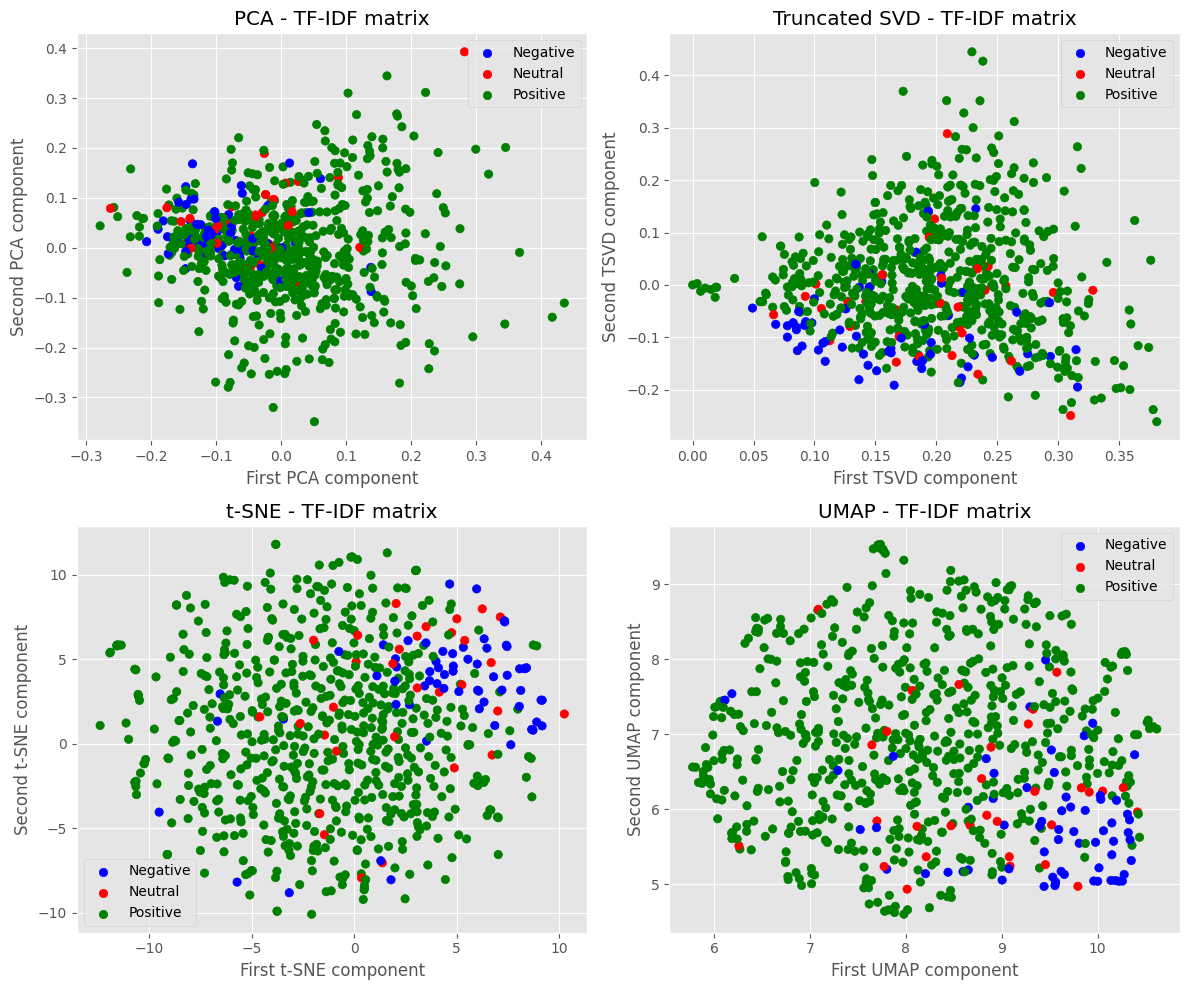

In [114]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
target_colors = ['blue', 'red', 'green']
target_labels = y.values
label_mapping = {2: "Positive", 1: "Neutral", 0: "Negative"}

# PCA
axes[0, 0].scatter(X_embedded_pca[:, 0], X_embedded_pca[:, 1], c=target_labels, cmap=ListedColormap(target_colors))
axes[0, 0].set_title("PCA - TF-IDF matrix")
axes[0, 0].set_xlabel("First PCA component")
axes[0, 0].set_ylabel("Second PCA component")
for value in set(target_labels):
    axes[0, 0].scatter([], [], color=target_colors[value], label=label_mapping[value])
axes[0, 0].legend()

# Truncated SVD
axes[0, 1].scatter(Tsvd[:, 0], Tsvd[:, 1], c=target_labels, cmap=ListedColormap(target_colors))
axes[0, 1].set_title("Truncated SVD - TF-IDF matrix")
axes[0, 1].set_xlabel("First TSVD component")
axes[0, 1].set_ylabel("Second TSVD component")
for value in set(target_labels):
    axes[0, 1].scatter([], [], color=target_colors[value], label=label_mapping[value])
axes[0, 1].legend()

# t-SNE
axes[1, 0].scatter(embedded_tsne[:, 1], embedded_tsne[:, 0], c=target_labels, cmap=ListedColormap(target_colors))
axes[1, 0].set_title("t-SNE - TF-IDF matrix")
axes[1, 0].set_xlabel("First t-SNE component")
axes[1, 0].set_ylabel("Second t-SNE component")
for value in set(target_labels):
    axes[1, 0].scatter([], [], color=target_colors[value], label=label_mapping[value])
axes[1, 0].legend()

# UMAP
umap_embedding = umap.UMAP(n_components=2).fit_transform(X)
axes[1, 1].scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=target_labels, cmap=ListedColormap(target_colors))
axes[1, 1].set_title("UMAP - TF-IDF matrix")
axes[1, 1].set_xlabel("First UMAP component")
axes[1, 1].set_ylabel("Second UMAP component")
for value in set(target_labels):
    axes[1, 1].scatter([], [], color=target_colors[value], label=label_mapping[value])
axes[1, 1].legend()

plt.tight_layout()
plt.show()

Unfortunately (from a visual point of view) by looking at the TF-IDF matrix visualizations we can't draw some impactful insights. For sure, we can say that the all reviews are pretty much aggregated in a single big cluster with some positive reviews outliers. The Neutral reviews are really neutral in fact they do not have a precise allocation on the plots, while for the negative reviews (especially by looking at the SVD plot) we note that they tend to have negative values along the second Truncated SVD component. The class imbalance is again clear.

But let's take a look at the cosine similarity matrix: here i hope to see the ground truth clusters defined slightly better.

In [115]:
# PCA
pca_result = pca.fit_transform(cos_sim)
pca_df = pd.DataFrame({'PC 1': pca_result[:, 0], 'PC 2': pca_result[:, 1], 'Sentiment': df['Sentiment']})

# Truncated SVD
Tsvd_cos = svd.fit_transform(cos_sim)
Tsvd_df = pd.DataFrame({'Tsvd 1': Tsvd_cos[:, 0], 'Tsvd 2': Tsvd_cos[:, 1], 'Sentiment': df['Sentiment']})

#t-SNE
tsne_cos = tsne.fit_transform(cos_sim)
tsne_df = pd.DataFrame({'t-SNE 1': tsne_cos[:, 0], 't-SNE 2': tsne_cos[:, 1], 'Sentiment': df['Sentiment']})

# UMAP
umap_cos = umap.UMAP(n_components=2).fit_transform(cos_sim)
umap_df = pd.DataFrame({'UMAP 1': umap_cos[:, 0], 'UMAP 2': umap_cos[:, 1], 'Sentiment': df['Sentiment']})

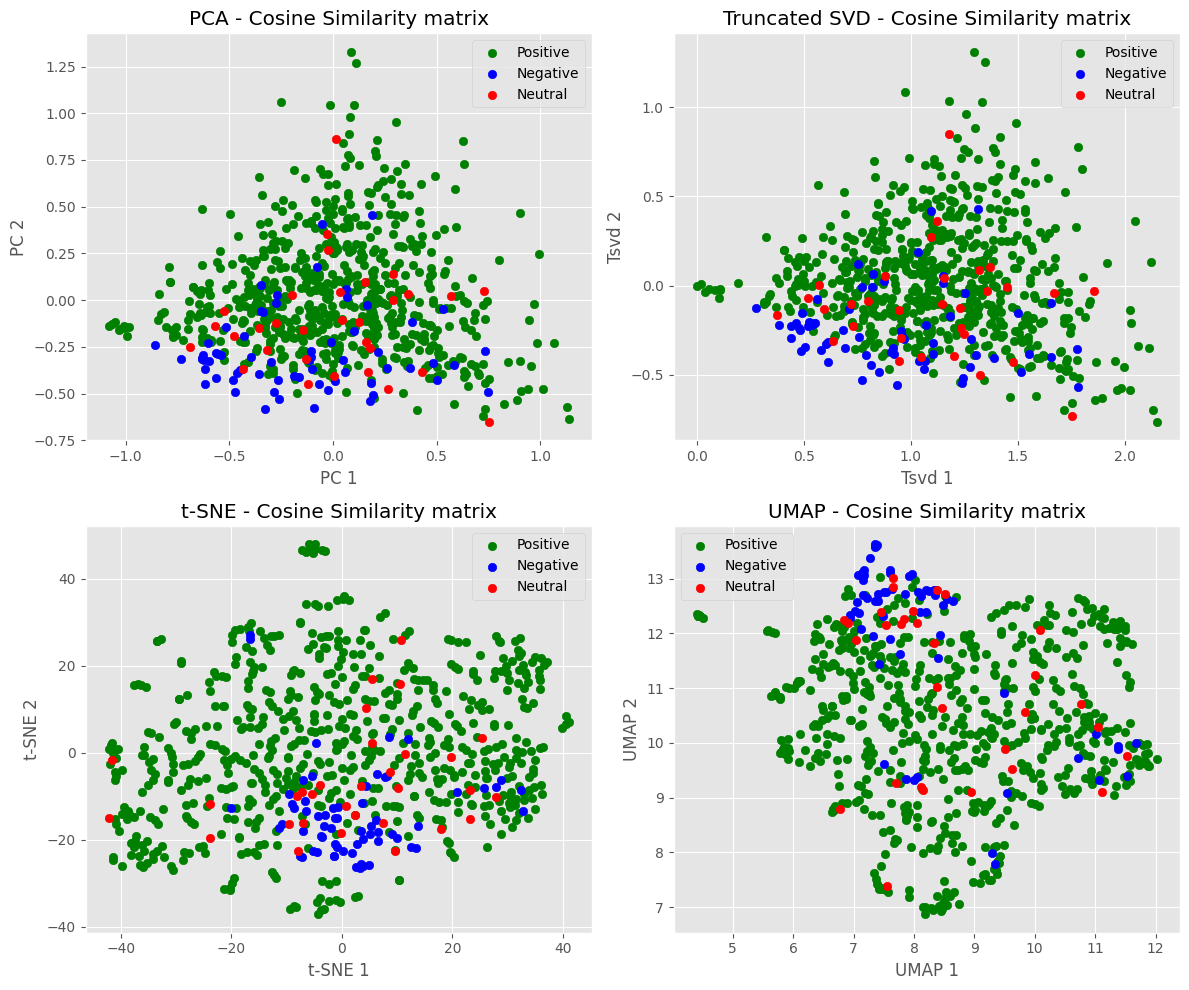

In [116]:
colors = {'Positive': 'green', 'Negative': 'blue', 'Neutral': 'red'}
sentiments = ['Positive', 'Negative', 'Neutral']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# PCA
ax1 = axes[0, 0]
for sentiment in sentiments:
    indices = pca_df['Sentiment'] == sentiment
    ax1.scatter(pca_df.loc[indices, 'PC 1'], pca_df.loc[indices, 'PC 2'], c=colors[sentiment], label=sentiment)
ax1.set_title('PCA - Cosine Similarity matrix')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.legend()

# Truncated SVD (Tsvd)
ax2 = axes[0, 1]
for sentiment in sentiments:
    indices = Tsvd_df['Sentiment'] == sentiment
    ax2.scatter(Tsvd_df.loc[indices, 'Tsvd 1'], Tsvd_df.loc[indices, 'Tsvd 2'], c=colors[sentiment], label=sentiment)
ax2.set_title('Truncated SVD - Cosine Similarity matrix')
ax2.set_xlabel('Tsvd 1')
ax2.set_ylabel('Tsvd 2')
ax2.legend()

# t-SNE
ax3 = axes[1, 0]
for sentiment in sentiments:
    indices = tsne_df['Sentiment'] == sentiment
    ax3.scatter(tsne_df.loc[indices, 't-SNE 1'], tsne_df.loc[indices, 't-SNE 2'], c=colors[sentiment], label=sentiment)
ax3.set_title('t-SNE - Cosine Similarity matrix')
ax3.set_xlabel('t-SNE 1')
ax3.set_ylabel('t-SNE 2')
ax3.legend()

# UMAP
ax4 = axes[1, 1]
for sentiment in sentiments:
    indices = umap_df['Sentiment'] == sentiment
    ax4.scatter(umap_df.loc[indices, 'UMAP 1'], umap_df.loc[indices, 'UMAP 2'], c=colors[sentiment], label=sentiment)
ax4.set_title('UMAP - Cosine Similarity matrix')
ax4.set_xlabel('UMAP 1')
ax4.set_ylabel('UMAP 2')
ax4.legend()

plt.tight_layout()
plt.show()

In this plot, the points with the PCA and the TSVD are nearly equally distributed and the negative positioning I talked about earlier is even more clear. In the UMAP we can now clearly see the random distribution of the Neutral reviews: it is good to have a confirmation in this sense since that is the reason they are neutral. Overall, negative reviews here are a bit more aggregated compared to the first plot.

Tried also 3D plots but were not interesting.

---
### SMOTE

It could be important to balance the classes in such situation. Here I use SMOTE (Synthetic Minority Oversampling Technique) to solve this problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them.

SMOTE synthesises new minority instances between existing minority instances: in simple words, it basically generates new synthetic training records by randomly selecting one or more of the k-nearest neighbors for each example in the minority class.

In [117]:
y.value_counts()

2    640
0     65
1     31
Name: Target, dtype: int64

In [118]:
y_train.value_counts()

2    450
0     44
1     21
Name: Target, dtype: int64

Showing again the class imbalance for completeness.

In [119]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f'After SMOTE, the shape of Target is: {Counter(y_train)}')

After SMOTE, the shape of Target is: Counter({1: 450, 2: 450, 0: 450})


In [120]:
print(f'The resampled sparse matrix has now dimension: {X_train.shape}')
print(f'The resampled target feature vector has now length: {len(y_train)}')

The resampled sparse matrix has now dimension: (1350, 2500)
The resampled target feature vector has now length: 1350


For obvious reasons, I have only balanced the train set.

---

## Feature Extraction and Selection

The sparse matrices are really large, and since we are working on a Classification task we could extract and select the most important/impactful n-grams to simplify the model training for example by using a chi-square test. But I decided to not perform this for 3 reasons: firstly the number of features (2500) was an arbitrary decision I could simply reduce if I wanted less features, secondly because I run the notebooks with different values of features and the changes in the models were not that impactful, and thirdly, plotting the feature importances after implementing a simple Random Forest Classifier, I noticed that the feature importance rates were generally really low.

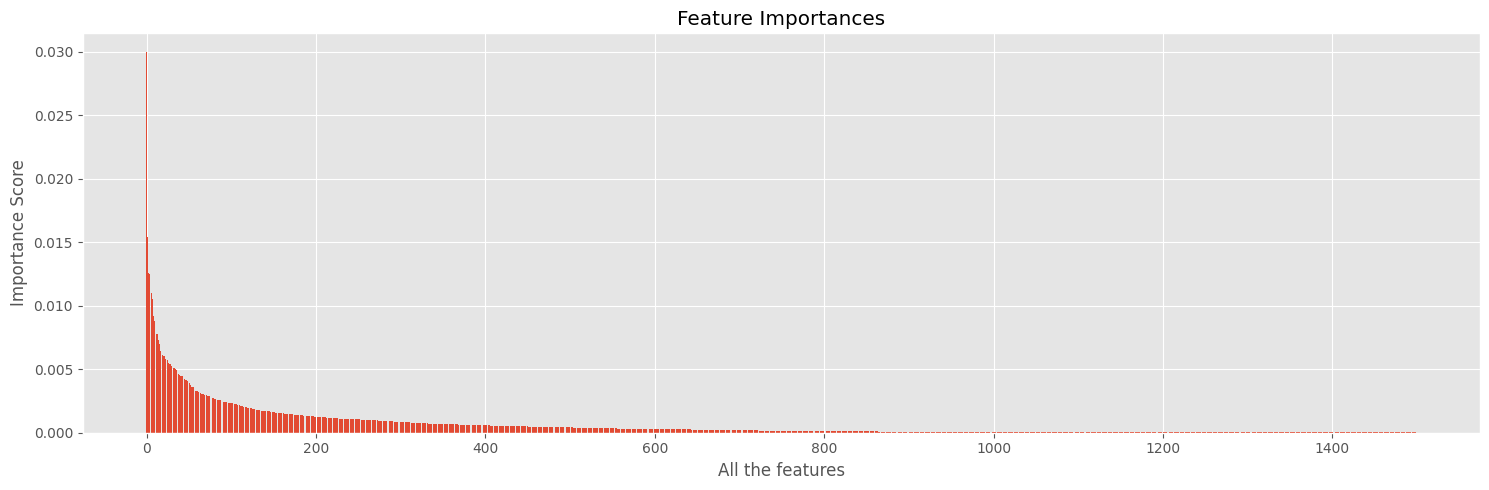

In [121]:
# train RF and get feature importances to sort them and plot
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_

# Sort
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

plt.figure(figsize=(15, 5))
# only first 1500 for making the plot prettier
plt.bar(range(len(sorted_importances)-1000), sorted_importances[:1500])
plt.xlabel('All the features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

As we can see we have really low feature importances. Let's see the top 10 features:

In [122]:
feature_names = tfidf.get_feature_names()
sorted_feature_names = [feature_names[idx] for idx in sorted_indices]
sorted_feature_names[:10]

['need',
 'worry',
 'rid',
 'monitor buy',
 'nice clear flat',
 'no main',
 'wife',
 'tone control',
 'amp',
 'power lead front']

Funny to see **wife** as a relevant feature. Probably better to be alone when playing music with these speakers.

Let's jump into the models.